In [119]:
pip install numpy scipy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [120]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [121]:
# The SL differential equation
# A pair of time series (x,y) is being modelled by the oscillator to capture the dominant frequency and the amplitude modulations
def stuart_landau_ode(t, z, beta, alpha, sigma):
    x, y = z
    r2 = x**2 + y**2
    dx = beta * x - alpha * y + sigma * x * r2
    dy = alpha * x + beta * y + sigma * y * r2
    return [dx, dy]

In [122]:
# The function that issues observations from the dynamical system
def generate_stuart_landau(T, beta, alpha, sigma, dt):
    # Initial conditions
    initial_conditions = [0.1, 0.1]
    t_span = (0, T)
    t_eval = np.arange(0, T, dt)

    # Solve the equations
    sol = solve_ivp(stuart_landau_ode, t_span, initial_conditions, args=(beta, alpha, sigma),
                    t_eval=t_eval, method='RK45')

    return sol.t, sol.y[0], sol.y[1]


T = 100
dt = 0.01
beta = 0.5
alpha = 0.6
sigma = 0.1

t = np.linspace(0, T, num=int(T/dt) + 1)
t, x, y = generate_stuart_landau(T, beta, alpha, sigma, dt)
print("Generated time series data successfully.")
print(f"Length of generated t: {len(t)}") # Debug: Check length of generated t

Generated time series data successfully.
Length of generated t: 553


In [123]:
print("t:", t, "x:", x, "y:", y)

t: [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53
 1.54 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67
 1.68 1.69 1.7  1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81
 1.82 1.83 1.84 1.85 1.86 1.87 1.88 1.89 1.9  1.91 1.92 1.93 1.94 1.95
 1.

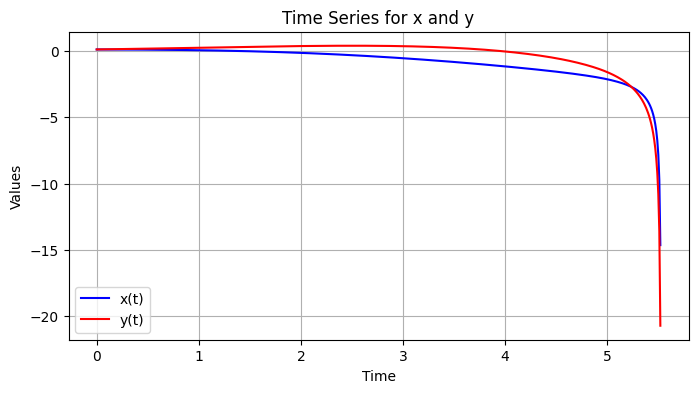

In [124]:
# Plotting the time series data for x and y on the same graph
plt.figure(figsize=(8, 4))  # Set the figure size

# Plot x and y on the same plot
plt.plot(t, x, label='x(t)', color='blue')  # Plot x in blue
plt.plot(t, y, label='y(t)', color='red')   # Plot y in red

plt.title('Time Series for x and y')
plt.xlabel('Time')
plt.ylabel('Values')
plt.grid(True)  # Enable grid for easier analysis
plt.legend()  # Add a legend to identify the lines

plt.show()  # Display the plot

In [125]:
# Learning the dynamical system equation i.e. finding the parameters that best explain the data

# Function to fit the parameters
def fit_parameters(t, x_data, y_data):
    # Function to simulate model within the fitting process
    def model_to_fit(t_eval_fit, beta, alpha, sigma):
        t_span = [t_eval_fit[0], t_eval_fit[-1]]
        sol = solve_ivp(stuart_landau_ode, t_span, [x_data[0], y_data[0]],
                        args=(beta, alpha, sigma),
                        dense_output=True,  # Enable dense output
                        method='RK45',
                        rtol=1e-8, atol=1e-10)

        # Interpolate the dense output solution at t_eval_fit points
        sol_interp = sol.sol(t_eval_fit) # Corrected line: use sol.sol to interpolate

        if len(sol_interp[0]) != len(t_eval_fit):
            raise RuntimeError(f"Expected solution length {len(t_eval_fit)}, but got {len(sol_interp[0])}")

        return np.concatenate((sol_interp[0], sol_interp[1]))

    # Concatenate x and y data for fitting
    combined_data = np.concatenate((x_data, y_data))

    # Initial guesses for parameters
    initial_guess = [1, 1, 0.01]

    # Fit the model to the data
    popt, pcov = curve_fit(model_to_fit, t, combined_data, p0=initial_guess, maxfev=2000)

    return popt, pcov

In [126]:
fitted_params, pcov = fit_parameters(t, x, y)
print("Fitted parameters:")
print(f"Fitted beta: {fitted_params[0]}")
print(f"Fitted alpha: {fitted_params[1]}")
print(f"Fitted sigma: {fitted_params[2]}")

Fitted parameters:
Fitted beta: 0.9999998887101412
Fitted alpha: 0.9999999999923007
Fitted sigma: 0.010000008504483878


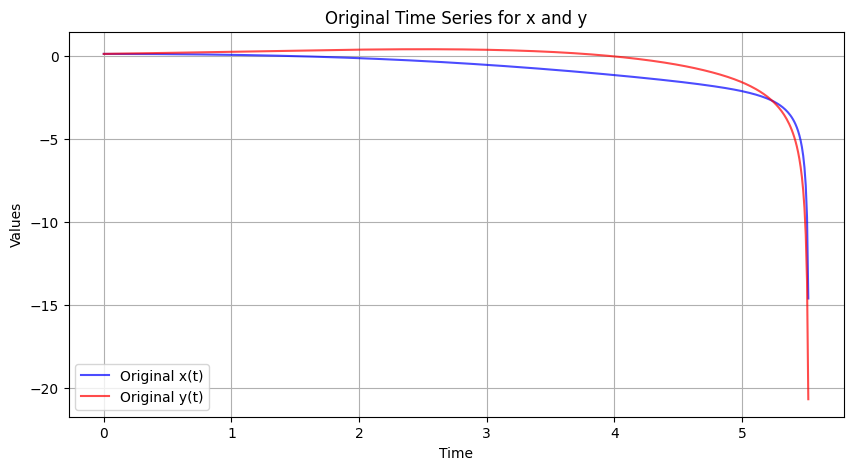

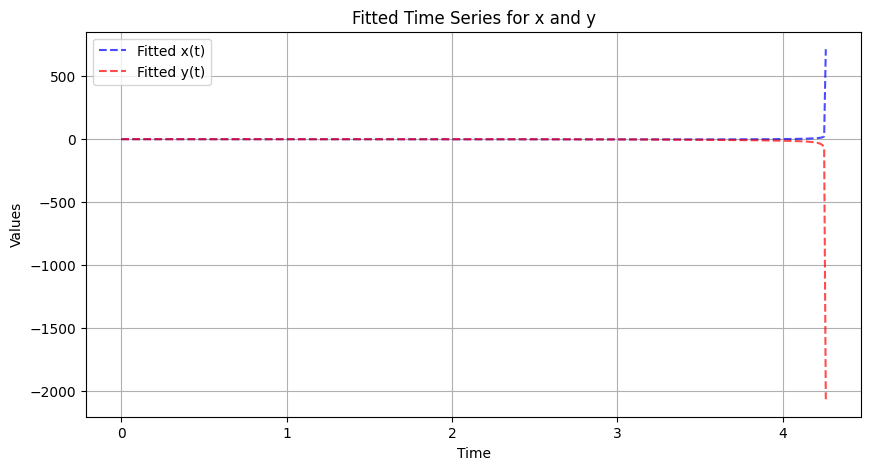

In [127]:
# Plotting both the original and fitted time series data
plt.figure(figsize=(10, 5))
plt.plot(t, x, 'b-', label='Original x(t)', alpha=0.7)  
plt.plot(t, y, 'r-', label='Original y(t)', alpha=0.7)  
plt.title('Original Time Series for x and y')
plt.xlabel('Time')
plt.ylabel('Values')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t_fitted, x_fitted, 'b--', label='Fitted x(t)', alpha=0.7)  
plt.plot(t_fitted, y_fitted, 'r--', label='Fitted y(t)', alpha=0.7)  
plt.title('Fitted Time Series for x and y')
plt.xlabel('Time')
plt.ylabel('Values')
plt.grid(True)
plt.legend()
plt.show()

In [130]:
print("Length of t:", len(t))
print("Length of x:", len(x))
print("Length of y:", len(y))
print("Length of t_fitted:", len(t_fitted))
print("Length of x_fitted:", len(x_fitted))
print("Length of y_fitted:", len(y_fitted))

Length of t: 553
Length of x: 553
Length of y: 553
Length of t_fitted: 427
Length of x_fitted: 427
Length of y_fitted: 427


In [131]:
import numpy as np
from scipy.interpolate import interp1d

# Assuming t, x, y are your longer dataset variables and t_fitted, x_fitted, y_fitted are the shorter
# First, create an interpolation function for the fitted data
interpolate_x_fitted = interp1d(t_fitted, x_fitted, kind='linear', bounds_error=False, fill_value="extrapolate")
interpolate_y_fitted = interp1d(t_fitted, y_fitted, kind='linear', bounds_error=False, fill_value="extrapolate")

# Now use the interpolation function to compute x_fitted and y_fitted at every point in t
x_fitted_aligned = interpolate_x_fitted(t)
y_fitted_aligned = interpolate_y_fitted(t)

# Verify the lengths now match
print("Length of x after interpolation:", len(x_fitted_aligned))
print("Length of y after interpolation:", len(y_fitted_aligned))

Length of x after interpolation: 553
Length of y after interpolation: 553


In [134]:
def calculate_rmse(observed, predicted):
    return np.sqrt(np.mean((observed - predicted) ** 2))

def calculate_mae(observed, predicted):
    return np.mean(np.abs(observed - predicted))

from sklearn.metrics import r2_score

def calculate_r2(observed, predicted):
    return r2_score(observed, predicted)

# Example calculation
rmse_x = calculate_rmse(x, x_fitted_aligned)
mae_x = calculate_mae(x, x_fitted_aligned)
r2_x = calculate_r2(x, x_fitted_aligned)

print("RMSE for x:", rmse_x)
print("MAE for x:", mae_x)
print("R^2 for x:", r2_x)

rmse_y = calculate_rmse(y, y_fitted_aligned)
mae_y = calculate_mae(y, y_fitted_aligned)
r2_y = calculate_r2(y, y_fitted_aligned)

print("RMSE for y:", rmse_y)
print("MAE for y:", mae_y)
print("R^2 for y:", r2_y)

RMSE for x: 0.7714616266340414
MAE for x: 0.14102688537504562
R^2 for x: 0.6252783905569336
RMSE for y: 1.316768745548795
MAE for y: 0.2858509488563409
R^2 for y: 0.3576599998244637


The model performs better in predicting 
𝑥
than 
𝑦
as indicated by lower RMSE and MAE values and a higher R² score for 
𝑥.
The RMSE values suggest that the model's predictions deviate from the actual observations significantly, more so for 
𝑦
than for 
𝑥.
The R² values indicate that the model's ability to explain the observed variance is moderate for 
𝑥
but relatively poor for 
𝑦, implying that improvements in model formulation or parameter estimation might be necessary for 
𝑦.